In [2]:
import pandas as pd 
import numpy as np 
import sys 

from datetime import datetime

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin

import matplotlib.pyplot as plt
from argparse import Namespace


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
input = pd.read_csv('./Data/input.csv')[0:20000]
labels = pd.read_csv('./Data/labels.csv')[0:20000]

In [5]:
def get_top_k_frequent(df, column_name, k=100):
    top_k_frequent = df[column_name].value_counts().head(k).index.tolist()
    return top_k_frequent

In [6]:
def replace_col_with_topk(df, column_name, top_k):
    # Identify values in `column_name` that are not in `top_k`
    condition = ~df[column_name].isin(top_k)
    
    # Replace values in `column_name` based on the condition
    df.loc[condition, column_name] = 'other'

In [7]:
def preprocess_data(df):
    now = datetime.now()

    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['days_since_recording'] = (now - df['date_recorded']).dt.days

    drop_columns = ['date_recorded', 'num_private', 'id', 'wpt_name', 'subvillage']
    for col in drop_columns:
        df.drop(col, axis=1, inplace=True)

    reduce_columns = ['ward','funder','installer', 'scheme_name']

    for column in reduce_columns:
        top_k = get_top_k_frequent(df, column)
        replace_col_with_topk(df, column, top_k)

    return df

In [8]:
input = preprocess_data(input)

In [263]:
input.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,days_since_recording
0,6000.0,other,1390,other,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,Ludewa,other,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,4745
1,0.0,other,1399,other,34.698766,-2.147466,Lake Victoria,Mara,20,2,Serengeti,other,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,4022
2,25.0,other,686,other,37.460664,-3.821329,Pangani,Manyara,21,4,Simanjiro,other,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,4031
3,0.0,other,263,other,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,other,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,4059
4,0.0,other,0,other,31.130847,-1.825359,Lake Victoria,Kagera,18,1,Karagwe,other,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,4624


In [301]:
def plot_cardinality(df, columns=[], type="All", save=False):
    filtered_df = df[columns]

    unique_counts = filtered_df.nunique()

    # plt.figure(figsize=(10,8))
    plt.bar(unique_counts.index.tolist(), unique_counts.values)
    plt.title(f'Cardinality of {type} Features', fontsize=14)
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Unique Values', fontsize=14)
    plt.xticks(rotation=90)  # Rotate labels to avoid overlap
    plt.tight_layout()

    if (save) : plt.savefig(f'./Figures/Cardinality/{type}.png')
    plt.show()
    

In [9]:
num_features = ['amount_tsh', 'gps_height', 'longitude','latitude', 'population', 'construction_year','days_since_recording']
cat_features = [feature for feature in input.columns if feature not in num_features]

In [10]:
labels.drop('id', axis=1, inplace=True)
labels = labels['status_group'].tolist()

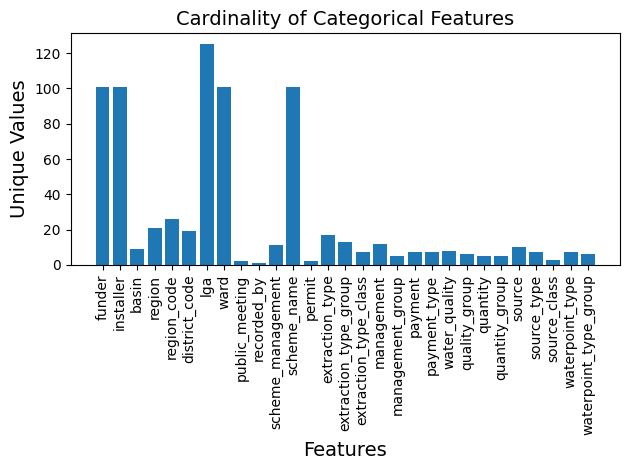

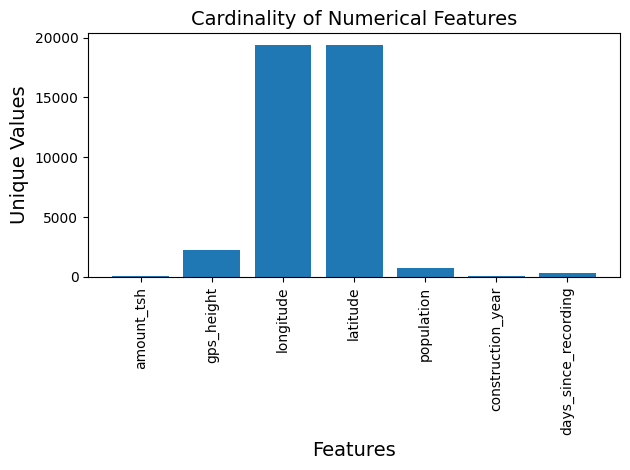

In [319]:
save = False
plot_cardinality(input, cat_features, 'Categorical', save)
plot_cardinality(input, num_features, 'Numerical', save)

In [11]:
onehot_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

In [12]:
ordinal_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Impute numerical features
            ('scaler', StandardScaler())
        ]), num_features),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute categorical features
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), cat_features)
    ]
)

In [13]:
target_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Impute numerical features
            ('scaler', StandardScaler())
        ]), num_features),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute categorical features
            ('encoder', TargetEncoder())
        ]), cat_features)
    ]
)

In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Gradient Boosting

### One Hot Encoding

In [324]:
grad_boost_model = Pipeline(steps=[('preprocessor', onehot_preprocessor),
                        ('classifier', GradientBoostingClassifier())])

In [325]:
scores = cross_val_score(grad_boost_model, input, labels, cv=kf, scoring='accuracy')

In [326]:
np.mean(scores)

0.7566499999999999

### Ordinal Encoding

In [215]:
grad_boost_model = Pipeline(steps=[('preprocessor', ordinal_preprocessor),
                        ('classifier', GradientBoostingClassifier())])

In [216]:
scores = cross_val_score(grad_boost_model, input, labels, cv=kf, scoring='accuracy')

In [217]:
np.mean(scores)

0.7524410774410775

In [211]:
scores

array([0.75934343, 0.76178451, 0.75993266, 0.76245791, 0.76018519])

### Target Encoding

In [219]:
grad_boost_model = Pipeline(steps=[('preprocessor', target_preprocessor),
                        ('classifier', GradientBoostingClassifier())])

In [220]:
scores = cross_val_score(grad_boost_model, input, labels, cv=kf, scoring='accuracy')

In [185]:
scores

array([0.78417508, 0.78240741, 0.78771044, 0.78063973, 0.78510101])

## Logistic Regression

### One Hot Encoding

In [189]:
grad_boost_model = Pipeline(steps=[('preprocessor', onehot_preprocessor),
                        ('classifier', LogisticRegression(max_iter=1000))])

In [190]:
scores = cross_val_score(grad_boost_model, input, labels, cv=kf, scoring='accuracy')
print(scores)

[0.79267677 0.79031987 0.79377104 0.78392256 0.79065657]


### Ordinal Encoding 

In [197]:
grad_boost_model = Pipeline(steps=[('preprocessor', ordinal_preprocessor),
                        ('classifier', LogisticRegression(solver='saga', max_iter=5000))])

In [198]:
scores = cross_val_score(grad_boost_model, input, labels, cv=kf, scoring='accuracy')
print(scores)

/home/jz75/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jz75/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jz75/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jz75/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jz75/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[0.59991582 0.5976431  0.59570707 0.59208754 0.59688552]


### Target Encoder 

In [202]:
grad_boost_model = Pipeline(steps=[('preprocessor', target_preprocessor),
                        ('classifier', LogisticRegression(max_iter=1000))])

In [ ]:
scores = cross_val_score(grad_boost_model, input, labels, cv=kf, scoring='accuracy')
print(scores)

## HistGradientBooster

In [17]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

### Target Encoder

In [18]:
model = Pipeline(steps=[('preprocessor', target_preprocessor),
                        ('classifier', HistGradientBoostingClassifier())])

In [19]:
scores = cross_val_score(model, input, labels, cv=kf, scoring='accuracy')
print(scores)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jz75/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jz75/.local/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/jz75/.local/lib/python3.9/site-packages/sklearn/pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
  File "/home/jz75/.local/lib/python3.9/site-packages/sklearn/pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/jz75/.local/lib/python3.9/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
  File "/home/jz75/.local/lib/python3.9/site-packages/sklearn/pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/home/jz75/.local/lib/python3.9/site-packages/sklearn/utils/_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/jz75/.local/lib/python3.9/site-packages/sklearn/base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/jz75/.local/lib/python3.9/site-packages/sklearn/utils/_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/tmp/ipykernel_2776797/1976835644.py", line 6, in transform
    return X.toarray()
AttributeError: 'numpy.ndarray' object has no attribute 'toarray'


### One Hot Encoder

In [247]:
model = Pipeline(steps=[
                        ('preprocessor', onehot_preprocessor),
                        ('to_dense', DenseTransformer()),
                        ('classifier', HistGradientBoostingClassifier())
                ])

In [248]:
scores = cross_val_score(model, input, labels, cv=kf, scoring='accuracy')
print(scores)

[0.7815  0.77825 0.7805  0.78175 0.78425]


### Ordinal Encoder 

In [327]:
model = Pipeline(steps=[
                        ('preprocessor', ordinal_preprocessor),
                        # ('to_dense', DenseTransformer()),
                        ('classifier', HistGradientBoostingClassifier())
                ])

In [328]:
scores = cross_val_score(model, input, labels, cv=kf, scoring='accuracy')
print(scores)

[0.792   0.786   0.7825  0.78175 0.788  ]


###

## Random Forrest 

### One Hot Encoding

In [329]:
random_forrest_model = Pipeline(steps=[('preprocessor', onehot_preprocessor),
                        ('classifier', RandomForestClassifier())])

In [330]:
scores = cross_val_score(random_forrest_model, input, labels, cv=kf, scoring='accuracy')
print(np.mean(scores))

0.78485


### Ordinal Encoding 

In [331]:
random_forrest_model = Pipeline(steps=[('preprocessor', ordinal_preprocessor),
                        ('classifier', RandomForestClassifier())])

In [332]:
scores = cross_val_score(random_forrest_model, input, labels, cv=kf, scoring='accuracy')
print(np.mean(scores))

0.78675


### Target Encoding 

In [333]:
random_forrest_model = Pipeline(steps=[('preprocessor', target_preprocessor),
                        ('classifier', RandomForestClassifier())])

In [334]:
scores = cross_val_score(random_forrest_model, input, labels, cv=kf, scoring='accuracy')
print(np.mean(scores))

0.77985


## MLP Classifier 

### One Hot Encoding 

In [338]:
mlp_model = Pipeline(steps=[('preprocessor', onehot_preprocessor),
                        ('classifier', MLPClassifier(max_iter=1000))])

In [339]:
scores = cross_val_score(mlp_model, input, labels, cv=kf, scoring='accuracy')
print(np.mean(scores))

0.7571999999999999


### Ordinal Encoding 

In [340]:
mlp_model = Pipeline(steps=[('preprocessor', ordinal_preprocessor),
                        ('classifier', MLPClassifier(max_iter=1000))])

scores = cross_val_score(mlp_model, input, labels, cv=kf, scoring='accuracy')
print(np.mean(scores))

0.71375


### Target Encoding 

In [15]:
mlp_model = Pipeline(steps=[('preprocessor', target_preprocessor),
                        ('classifier', MLPClassifier(max_iter=1000))])

scores = cross_val_score(mlp_model, input, labels, cv=kf, scoring='accuracy')
print(np.mean(scores))

0.75305
